# 상위 10% 고객 대상 3개 집단 분석

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
pip install PyMySQL

In [ ]:
import pymysql
import pandas as pd

# MySQL 연결 설정
conn = pymysql.connect(
    host='localhost',  # MySQL 호스트
    user='root',  # MySQL 사용자명
    password= ,  # MySQL 비밀번호
    database='project',  # 사용할 데이터베이스
    charset='utf8mb4'
)

# SQL 실행
query = """
SELECT 
    o.user_id, 
    o.order_id, 
    op.product_id, 
    p.product_name, 
    a.aisle, 
    d.department,
    o.order_dow, 
    o.order_hour_of_day, 
    o.days_since_prior_order,
    op.reordered
FROM (
    SELECT user_id, MAX(order_number) AS total_orders
    FROM orders
    GROUP BY user_id
    HAVING total_orders >= 38
) u
JOIN orders o ON u.user_id = o.user_id
JOIN order_products_prior op ON o.order_id = op.order_id
JOIN products p ON op.product_id = p.product_id
JOIN aisles a ON p.aisle_id = a.aisle_id
JOIN departments d ON p.department_id = d.department_id;
"""

# Pandas DataFrame으로 변환
top_10_percent_cus = pd.read_sql(query, conn)

# MySQL 연결 종료
conn.close()

# 데이터 확인
print(top_10_percent_cus.head())


In [ ]:
# 사용자-진열대 행렬 만들기 (상위 10프로 사용자가 각 aisle에서 주문한 횟수)
top_aisle_matrix = top_10_percent_cus.pivot_table(index='user_id', columns='aisle', aggfunc='size', fill_value=0)

# 데이터 확인
print(top_aisle_matrix.head())

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# 사용자 간 코사인 유사도 계산
top_similarity_ais = cosine_similarity(top_aisle_matrix)

# 유사도 DataFrame 변환
top_similarity_df_ais = pd.DataFrame(top_similarity_ais, index=top_aisle_matrix.index, columns=top_aisle_matrix.index)


In [ ]:
from sklearn.cluster import KMeans

# 클러스터 개수 설정 (적절한 값으로 조정 가능)
num_clusters = 3  

# K-Means 클러스터링 수행
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
user_clusters = kmeans.fit_predict(top_similarity_ais)

# 결과를 DataFrame에 저장
top_similarity_df_ais["cluster"] = user_clusters

# 각 user_id의 클러스터 확인
print(top_similarity_df_ais[["cluster"]].head())

In [ ]:
from sklearn.decomposition import PCA

# PCA를 사용하여 2차원으로 축소
pca = PCA(n_components=2)
user_pca = pca.fit_transform(top_similarity_ais)

# 결과를 DataFrame에 저장
top_similarity_df_ais["pca_x"] = user_pca[:, 0]
top_similarity_df_ais["pca_y"] = user_pca[:, 1]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="pca_x",
    y="pca_y",
    hue="cluster",
    palette="tab10",
    data=top_similarity_df_ais,
    alpha=0.7
)
plt.title("User Clustering Visualization (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# 1️⃣ 클러스터 정보를 사용자 데이터(`top_10_percent_cus`)와 결합
top_10_percent_cus = top_10_percent_cus.merge(
    top_similarity_df_ais[["cluster"]],
    left_on="user_id",
    right_index=True,
    how="left"
)

In [ ]:
# 2️⃣ 클러스터별 Aisle 주문 횟수 집계
cluster_aisle_counts = top_10_percent_cus.groupby(["cluster", "aisle"])["order_id"].count().reset_index()
print(cluster_aisle_counts) 

In [ ]:
# 3️⃣ 클러스터별 상위 5개 Aisle 추출 (중복 인덱스 문제 해결)
top_aisles_per_cluster = (
    cluster_aisle_counts.groupby("cluster")
    .apply(lambda x: x.nlargest(5, "order_id"))
    .reset_index(drop=True)  
)
print(top_aisles_per_cluster)

In [ ]:
# cluster가 0인 데이터 필터링
cluster_0_data = top_10_percent_cus[top_10_percent_cus["cluster"] == 0]

# CSV 파일로 저장 (UTF-8 인코딩)
cluster_0_data.to_csv("cluster_0_new_data.csv", index=False, encoding="utf-8")

print("New 클러스터 0 데이터 저장 완료!")

In [ ]:
# cluster가 1인 데이터 필터링
cluster_1_data = top_10_percent_cus[top_10_percent_cus["cluster"] == 1]

# CSV 파일로 저장 (UTF-8 인코딩)
cluster_1_data.to_csv("cluster_1_new_data.csv", index=False, encoding="utf-8")

print("New 클러스터 1 데이터 저장 완료!")

In [ ]:
# cluster가 2인 데이터 필터링
cluster_2_data = top_10_percent_cus[top_10_percent_cus["cluster"] == 2]

# CSV 파일로 저장 (UTF-8 인코딩)
cluster_2_data.to_csv("cluster_2_new_data.csv", index=False, encoding="utf-8")

print("New 클러스터 2 데이터 저장 완료!")

##  cluster 0 - blue

In [10]:
cluster_0 = pd.read_csv('cluster_0_new_data.csv')

In [11]:
cluster_0

,user_id,order_id,product_id,product_name,aisle,department,order_dow,order_hour_of_day,days_since_prior_order,reordered,cluster
0,2335,1509,635,Little Bites Snickerdoodle Muffins,cookies cakes,snacks,6,19,7.0,1.0,0
1,2688,3218,1117,Turkey Bacon,hot dogs bacon sausage,meat seafood,1,13,6.0,1.0,0
2,3273,4094,782,"85% Lean, 15% Fat Ground Turkey (013021)",packaged poultry,meat seafood,0,11,7.0,0.0,0
3,4076,255,872,Power Greens,refrigerated,beverages,0,20,3.0,1.0,0
4,4326,5625,432,Vanilla Almond Breeze Almond Milk,soy lactosefree,dairy eggs,5,9,8.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
2213090,187842,2235479,38985,Organic Stage 4 Spinach Mango & Pear Baby Food,baby food formula,babies,0,13,1.0,1.0,0
2213091,199511,1749471,42987,Krinkle Cut Salt & Fresh Ground Pepper Potato ...,chips pretzels,snacks,0,14,7.0,0.0,0
2213092,204237,2282118,26209,Limes,fresh fruits,produce,0,8,5.0,0.0,0
2213093,204748,2171938,10798,Organic Salted Individually Wrapped Quarters B...,butter,dairy eggs,1,20,7.0,1.0,0


### 집단별 특성 분석 - aisle

In [13]:
cluster_0['aisle'].value_counts().head(10)

aisle
fresh fruits                     266327
yogurt                           130276
packaged vegetables fruits       105227
fresh vegetables                  99173
milk                              76943
water seltzer sparkling water     72912
packaged cheese                   66457
chips pretzels                    62257
soy lactosefree                   50499
refrigerated                      49926
Name: count, dtype: int64

/var/folders/_n/svy9wdnj40n4g_jzln84knw40000gn/T/ipykernel_4906/1030347952.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


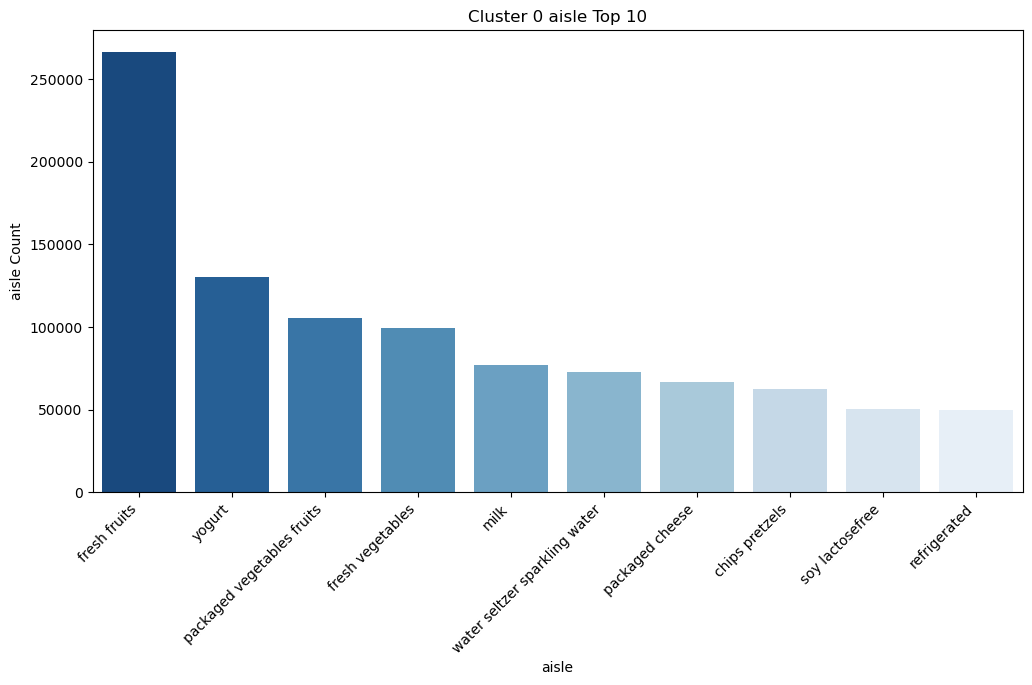

In [14]:
df = cluster_0['aisle'].value_counts().reset_index().head(10)
df.columns = ['aisle', 'count']

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x="aisle",
    y="count",
    palette="Blues_r"
)

# X축 레이블 회전 및 정렬
plt.xticks(rotation=45, ha="right")
plt.xlabel("aisle")
plt.ylabel("aisle Count")
plt.title("Cluster 0 aisle Top 10")

# 그래프 출력
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import squarify

# 상위 10개 진열대(aisle) 계산
aisle_counts_0 = cluster_0_data["aisle"].value_counts().nlargest(10)

# 파란색 계열 컬러 설정 (큰 값일수록 진한 색이 되도록 뒤집기)
colors = sns.color_palette("Blues", len(aisle_counts_0))[::-1]  # 색상 리스트를 뒤집음

# 트리맵 그리기
plt.figure(figsize=(10, 6))
squarify.plot(sizes=aisle_counts_0.values, label=aisle_counts_0.index, alpha=0.8, color=colors)
plt.title("Top 10 Aisles in Cluster 0 (Tree Map)", fontsize=14)
plt.axis("off")
plt.show()


In [15]:
cluster_0[['aisle', 'product_name']].value_counts().head(30).reset_index()

,aisle,product_name,count
0,fresh fruits,Banana,37977
1,fresh fruits,Bag of Organic Bananas,31023
2,fresh fruits,Organic Strawberries,16448
3,fresh fruits,Strawberries,12571
4,fresh fruits,Organic Hass Avocado,11169
5,packaged vegetables fruits,Organic Raspberries,10625
6,packaged vegetables fruits,Organic Baby Spinach,10138
7,fresh fruits,Organic Fuji Apple,8726
8,milk,Organic Whole Milk,8326
9,cream,Organic Half & Half,8118


### 집단별 주문 시간 + 요일 - order_hour_of_day, order_dow

In [17]:
# 요일 + 시간

cluster_0[['order_hour_of_day','order_dow']].value_counts().unstack()

order_dow,0,1,2,3,4,5,6
order_hour_of_day,,,,,,,
0,1755,2558,1454,1311,1401,1644,1706
1,929,1387,810,747,555,793,969
2,591,651,633,429,440,569,863
3,463,417,330,358,357,476,577
4,594,531,408,384,400,491,566
5,650,1462,804,937,798,885,618
6,2273,4698,3523,3553,3240,3138,2050
7,9084,15522,9390,9137,9558,9636,8124
8,18640,35127,19179,17103,15998,18438,15407


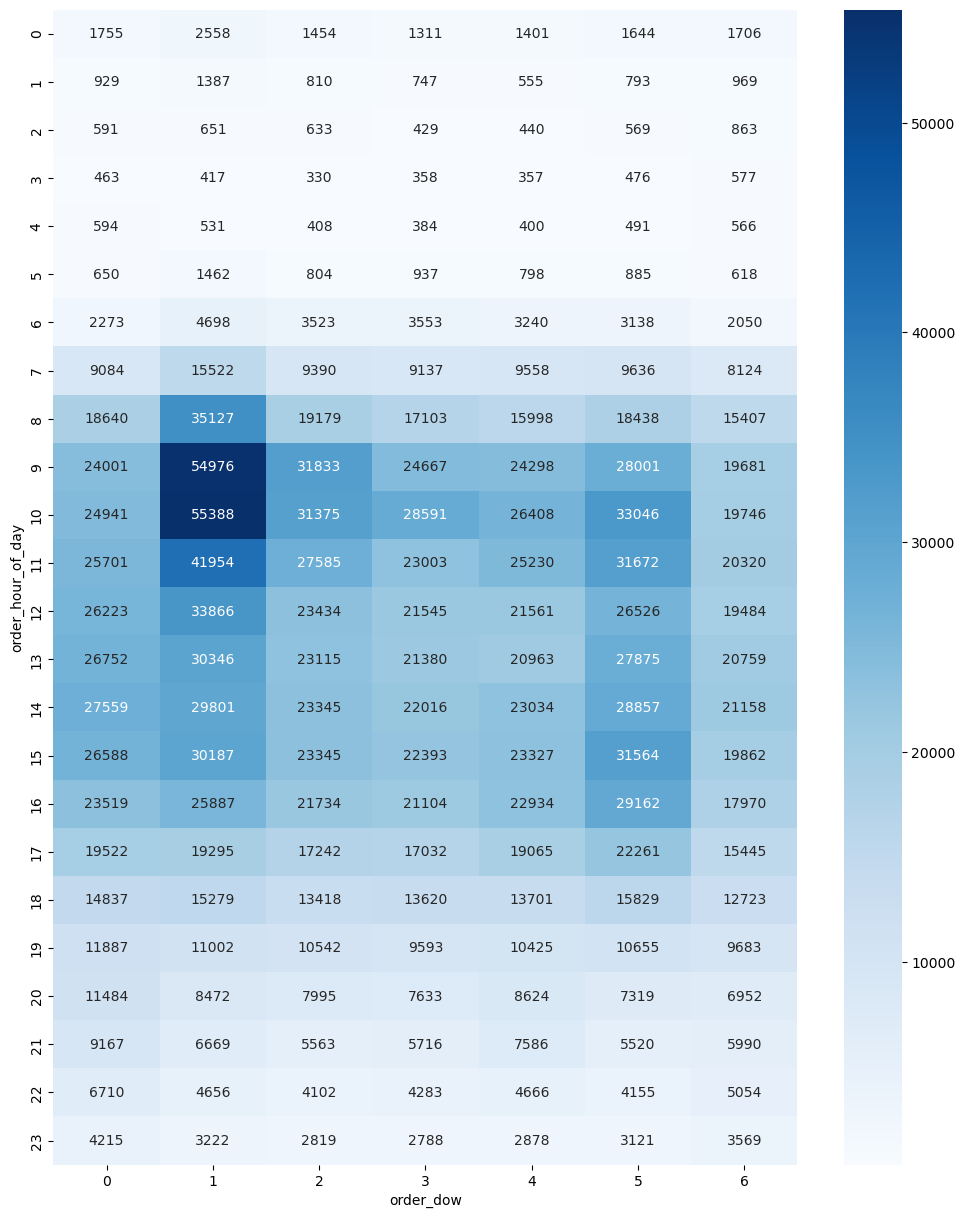

In [18]:
df = cluster_0[['order_hour_of_day','order_dow']].value_counts().unstack()

plt.figure(figsize=(12, 15))
sns.heatmap(df, annot = True, cmap = "Blues",fmt = '.0f')
plt.show()

### 집단별 재구매 주기 - days_since_prior_order

In [20]:
cluster_0['days_since_prior_order'].describe().apply(lambda x: format(x, '.2f'))

count    2170477.00
mean           6.38
std            4.76
min            0.00
25%            3.00
50%            6.00
75%            8.00
max           30.00
Name: days_since_prior_order, dtype: object

/var/folders/_n/svy9wdnj40n4g_jzln84knw40000gn/T/ipykernel_4906/1827625504.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


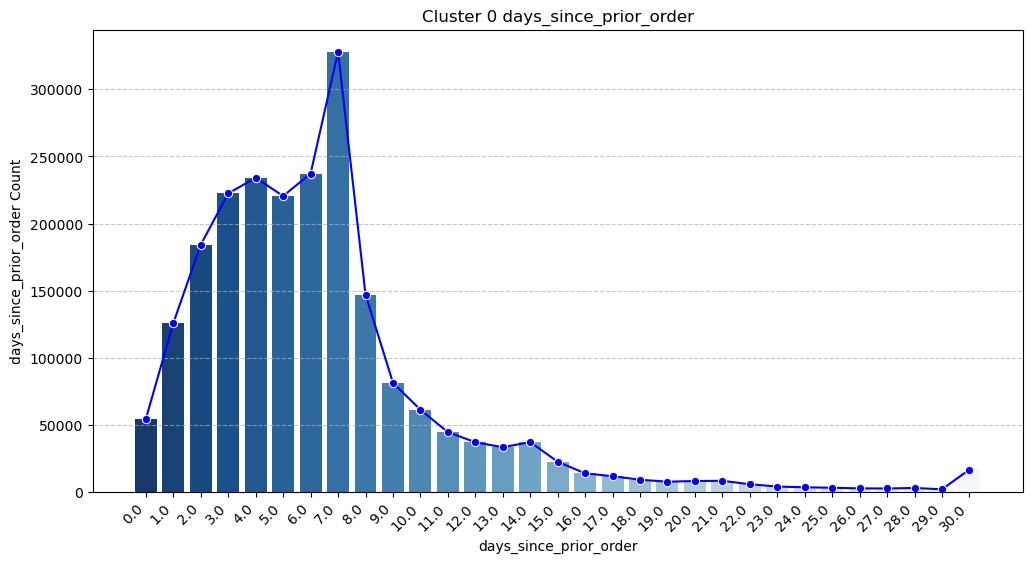

In [21]:
df = cluster_0['days_since_prior_order'].value_counts().reset_index()
df.columns = ['days_since_prior_order', 'count']

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x="days_since_prior_order",
    y="count",
    palette="Blues_r"
)
sns.lineplot(
    data=df,
    x="days_since_prior_order",
    y="count",
    color="Blue",
    marker="o" 
)

# X축 레이블 회전 및 정렬
plt.xticks(rotation=45, ha="right")
plt.xlabel("days_since_prior_order")
plt.ylabel("days_since_prior_order Count")
plt.title("Cluster 0 days_since_prior_order")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 출력
plt.show()


##  cluster 1 - orange

In [23]:
cluster_1 = pd.read_csv('cluster_1_new_data.csv')

In [24]:
cluster_1

,user_id,order_id,product_id,product_name,aisle,department,order_dow,order_hour_of_day,days_since_prior_order,reordered,cluster
0,90,1483,1545,"Healthy Grains Granola Bar, Vanilla Blueberry",energy granola bars,snacks,3,13,5.0,1.0,1
1,90,1483,1831,Peach-Pear Sparkling Water,water seltzer sparkling water,beverages,3,13,5.0,1.0,1
2,222,4163,432,Vanilla Almond Breeze Almond Milk,soy lactosefree,dairy eggs,2,10,1.0,1.0,1
3,4297,2510,25,Salted Caramel Lean Protein & Fiber Bar,energy granola bars,snacks,4,12,6.0,1.0,1
4,4297,2510,93,Uncured Cracked Pepper Beef,popcorn jerky,snacks,4,12,6.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
923699,160358,1676029,4724,Broccoli Florettes,packaged produce,produce,3,17,9.0,0.0,1
923700,175760,2368380,4724,Broccoli Florettes,packaged produce,produce,2,7,7.0,1.0,1
923701,176604,1685431,26209,Limes,fresh fruits,produce,5,13,4.0,1.0,1
923702,176604,1685431,7600,Mild Chunky Salsa,preserved dips spreads,pantry,5,13,4.0,1.0,1


### 집단별 특성 분석 - aisle

In [26]:
cluster_1['aisle'].value_counts().head(10)

aisle
water seltzer sparkling water    54962
yogurt                           54208
fresh fruits                     37810
milk                             33011
soft drinks                      31005
chips pretzels                   30123
energy granola bars              28498
refrigerated                     26185
candy chocolate                  22551
packaged cheese                  21751
Name: count, dtype: int64

/var/folders/_n/svy9wdnj40n4g_jzln84knw40000gn/T/ipykernel_4906/2298572858.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


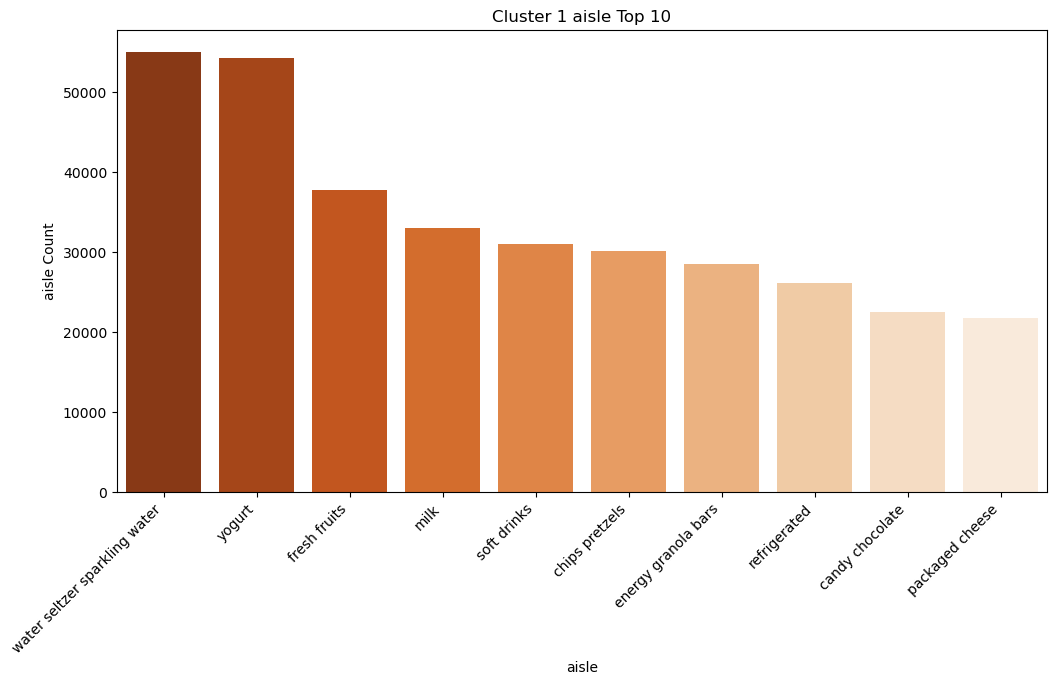

In [27]:
df = cluster_1['aisle'].value_counts().reset_index().head(10)
df.columns = ['aisle', 'count']

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x="aisle",
    y="count",
    palette="Oranges_r"
)

# X축 레이블 회전 및 정렬
plt.xticks(rotation=45, ha="right")
plt.xlabel("aisle")
plt.ylabel("aisle Count")
plt.title("Cluster 1 aisle Top 10")

# 그래프 출력
plt.show()

In [ ]:
# 상위 10개 진열대(aisle) 계산
aisle_counts_1 = cluster_1_data["aisle"].value_counts().nlargest(10)

# 파란색 계열 컬러 설정 (큰 값일수록 진한 색이 되도록 뒤집기)
colors = sns.color_palette("Oranges", len(aisle_counts_1))[::-1]  # 색상 리스트를 뒤집음

# 트리맵 그리기
plt.figure(figsize=(10, 6))
squarify.plot(sizes=aisle_counts_1.values, label=aisle_counts_1.index, alpha=0.8, color=colors)
plt.title("Top 10 Aisles in Cluster 1 (Tree Map)", fontsize=14)
plt.axis("off")
plt.show()

In [28]:
cluster_1[['aisle', 'product_name']].value_counts().head(30).reset_index()

,aisle,product_name,count
0,fresh fruits,Banana,5929
1,soft drinks,Soda,5613
2,fresh fruits,Bag of Organic Bananas,4659
3,cream,Organic Half & Half,4438
4,water seltzer sparkling water,Sparkling Water Grapefruit,4413
5,cream,Half & Half,3849
6,packaged produce,Clementines,3238
7,water seltzer sparkling water,Lime Sparkling Water,2995
8,water seltzer sparkling water,Spring Water,2875
9,packaged produce,Hass Avocados,2846


### 집단별 주문 시간 + 요일 - order_hour_of_day, order_dow¶

In [30]:
# 요일 + 시간

cluster_1[['order_hour_of_day','order_dow']].value_counts().unstack()

order_dow,0,1,2,3,4,5,6
order_hour_of_day,,,,,,,
0,686,982,843,739,550,595,603
1,559,487,267,305,325,348,443
2,330,322,236,165,224,307,383
3,242,154,224,109,175,220,264
4,181,340,118,228,229,297,214
5,291,421,359,347,301,392,465
6,765,1798,1400,1168,1072,1262,701
7,2135,5537,3714,3074,3368,3853,2678
8,4195,14272,9467,8121,7513,7659,4204


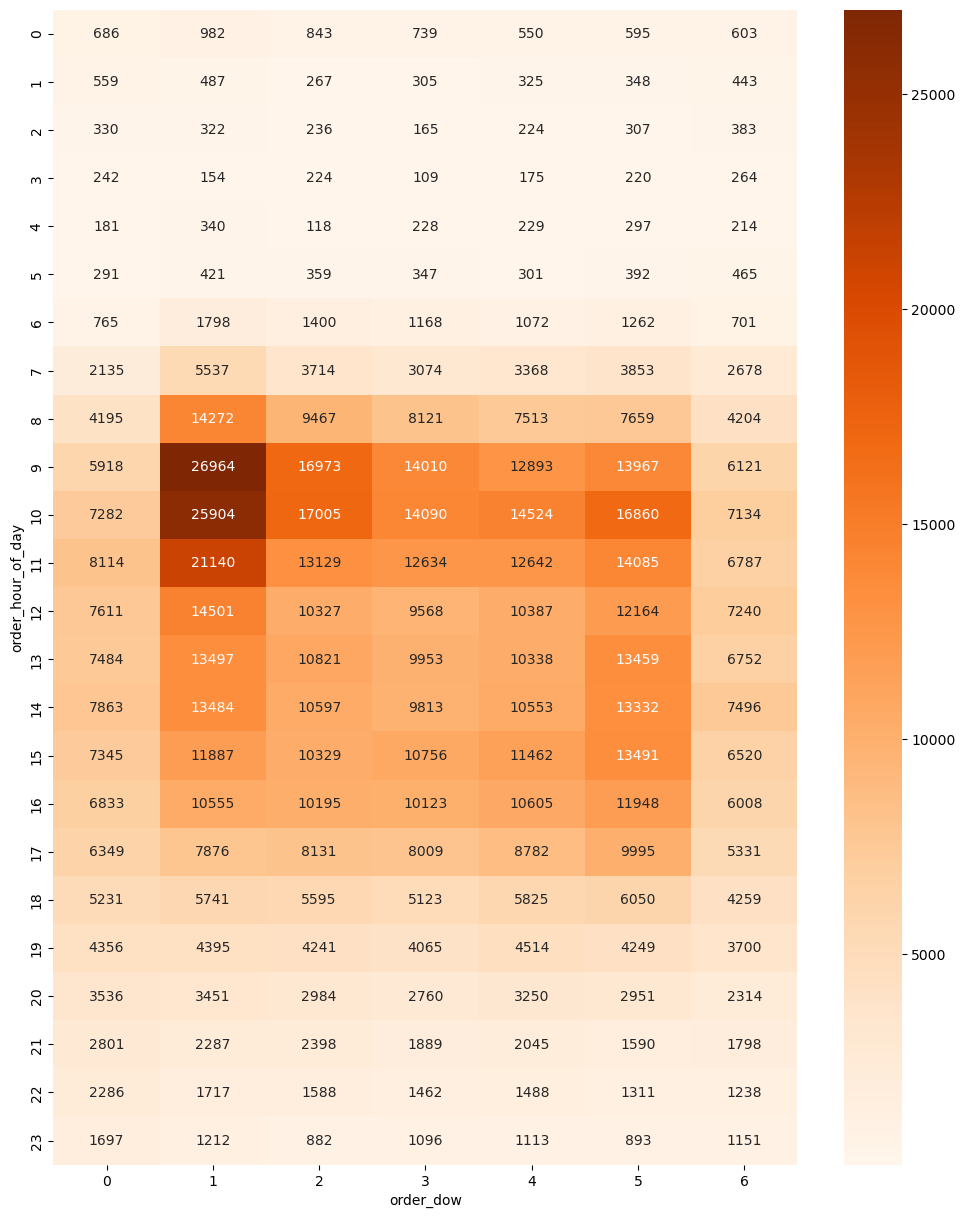

In [31]:
df = cluster_1[['order_hour_of_day','order_dow']].value_counts().unstack()

plt.figure(figsize=(12, 15))
sns.heatmap(df, annot = True, cmap = "Oranges", fmt = '.0f')
plt.show()

### 집단별 재구매 주기 - days_since_prior_order

In [33]:
cluster_1['days_since_prior_order'].describe().apply(lambda x: format(x, '.2f'))

count    906252.00
mean          6.26
std           4.74
min           0.00
25%           3.00
50%           6.00
75%           8.00
max          30.00
Name: days_since_prior_order, dtype: object

/var/folders/_n/svy9wdnj40n4g_jzln84knw40000gn/T/ipykernel_4906/619004366.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


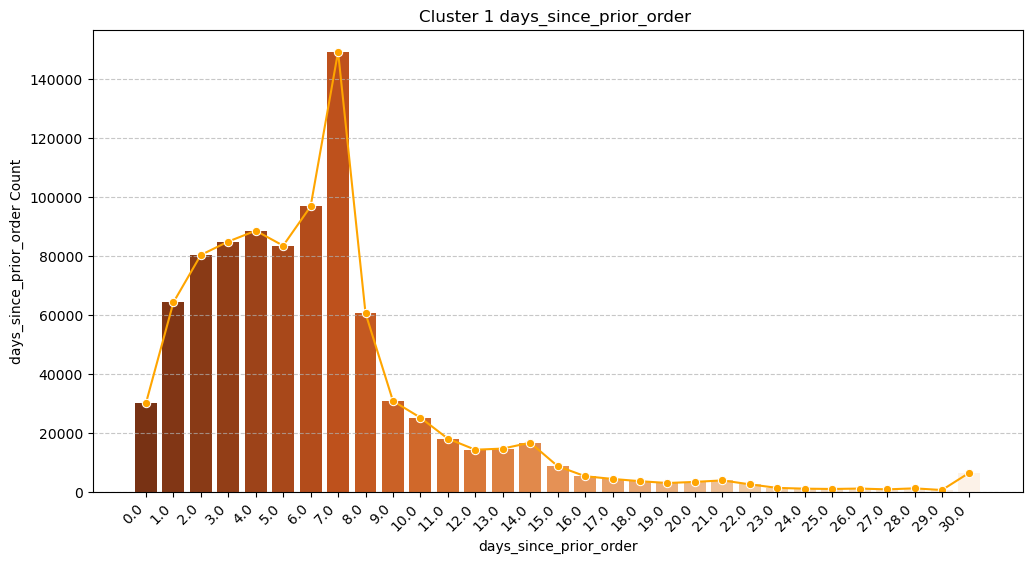

In [34]:
df = cluster_1['days_since_prior_order'].value_counts().reset_index()
df.columns = ['days_since_prior_order', 'count']

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x="days_since_prior_order",
    y="count",
    palette="Oranges_r"
)
sns.lineplot(
    data=df,
    x="days_since_prior_order",
    y="count",
    color="Orange",
    marker="o" 
)


# X축 레이블 회전 및 정렬
plt.xticks(rotation=45, ha="right")
plt.xlabel("days_since_prior_order")
plt.ylabel("days_since_prior_order Count")
plt.title("Cluster 1 days_since_prior_order ")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 출력
plt.show()

## cluster 2 - green

In [36]:
cluster_2 = pd.read_csv('cluster_2_new_data.csv')

In [37]:
cluster_2

,user_id,order_id,product_id,product_name,aisle,department,order_dow,order_hour_of_day,days_since_prior_order,reordered,cluster
0,1264,889,1374,Organic Hass Avocado Bag,fresh vegetables,produce,1,7,4.0,1.0,2
1,1378,2863,781,Organic Shredded Mild Cheddar,packaged cheese,dairy eggs,2,14,6.0,0.0,2
2,3974,4949,1695,Major Dickason's Blend Ground Coffee Dark Roast,coffee,beverages,3,18,13.0,1.0,2
3,4789,4604,1463,Organic Milk,milk,dairy eggs,0,19,6.0,1.0,2
4,5927,289,920,Coconut Yogurt,yogurt,dairy eggs,0,8,7.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...
5013003,200194,1932547,47104,Banana Oat Bars,energy granola bars,snacks,0,12,2.0,1.0,2
5013004,200790,1685209,26209,Limes,fresh fruits,produce,0,10,8.0,1.0,2
5013005,202833,2008884,37131,Tomato Yellow Cherry,fresh vegetables,produce,1,11,5.0,1.0,2
5013006,204173,1605498,26209,Limes,fresh fruits,produce,0,22,9.0,1.0,2


### 집단별 특성 분석 - aisle

In [39]:
cluster_2['aisle'].value_counts().head(10)

aisle
fresh vegetables                 745317
fresh fruits                     709007
packaged vegetables fruits       328103
yogurt                           216105
packaged cheese                  156504
milk                             151744
soy lactosefree                  100784
bread                             94887
water seltzer sparkling water     87183
fresh herbs                       84808
Name: count, dtype: int64

/var/folders/_n/svy9wdnj40n4g_jzln84knw40000gn/T/ipykernel_4906/651567674.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


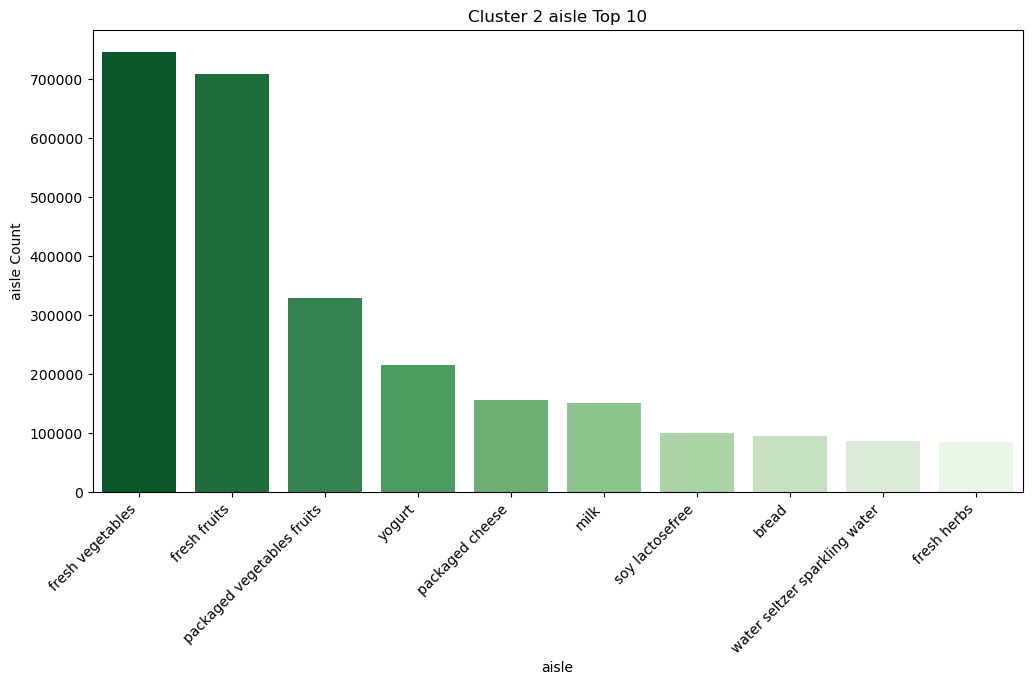

In [40]:
df = cluster_2['aisle'].value_counts().reset_index().head(10)
df.columns = ['aisle', 'count']

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x="aisle",
    y="count",
    palette="Greens_r"
)

# X축 레이블 회전 및 정렬
plt.xticks(rotation=45, ha="right")
plt.xlabel("aisle")
plt.ylabel("aisle Count")
plt.title("Cluster 2 aisle Top 10")

# 그래프 출력
plt.show()

In [ ]:
# 상위 10개 진열대(aisle) 계산
aisle_counts_2 = cluster_2_data["aisle"].value_counts().nlargest(10)

# 파란색 계열 컬러 설정 (큰 값일수록 진한 색이 되도록 뒤집기)
colors = sns.color_palette("Greens", len(aisle_counts_1))[::-1]  # 색상 리스트를 뒤집음

# 트리맵 그리기
plt.figure(figsize=(10, 6))
squarify.plot(sizes=aisle_counts_2.values, label=aisle_counts_2.index, alpha=0.8, color=colors)
plt.title("Top 10 Aisles in Cluster 2 (Tree Map)", fontsize=14)
plt.axis("off")
plt.show()

In [41]:
cluster_2[['aisle', 'product_name']].value_counts().head(30).reset_index()

,aisle,product_name,count
0,fresh fruits,Banana,79450
1,fresh fruits,Bag of Organic Bananas,77695
2,fresh fruits,Organic Strawberries,63789
3,fresh fruits,Organic Hass Avocado,53070
4,packaged vegetables fruits,Organic Baby Spinach,50950
5,milk,Organic Whole Milk,33185
6,fresh fruits,Organic Avocado,32959
7,packaged vegetables fruits,Organic Raspberries,31561
8,fresh fruits,Limes,29940
9,fresh vegetables,Organic Yellow Onion,29185


### 집단별 주문 시간 + 요일 - order_hour_of_day, order_dow¶

In [43]:
# 요일 + 시간

cluster_2[['order_hour_of_day','order_dow']].value_counts().unstack()

order_dow,0,1,2,3,4,5,6
order_hour_of_day,,,,,,,
0,6099,5158,4089,4053,3669,4514,4553
1,2965,2484,1900,1974,1878,1908,2648
2,1604,1295,1065,1188,1218,1208,1230
3,1226,989,1036,710,720,921,935
4,1026,1113,1098,961,1017,1244,1372
5,2094,2487,2092,1876,1913,2436,1825
6,7008,10984,8431,7632,8326,9898,5675
7,28005,31431,22753,21617,22277,25726,24522
8,61871,55107,36363,32983,35822,40676,46685


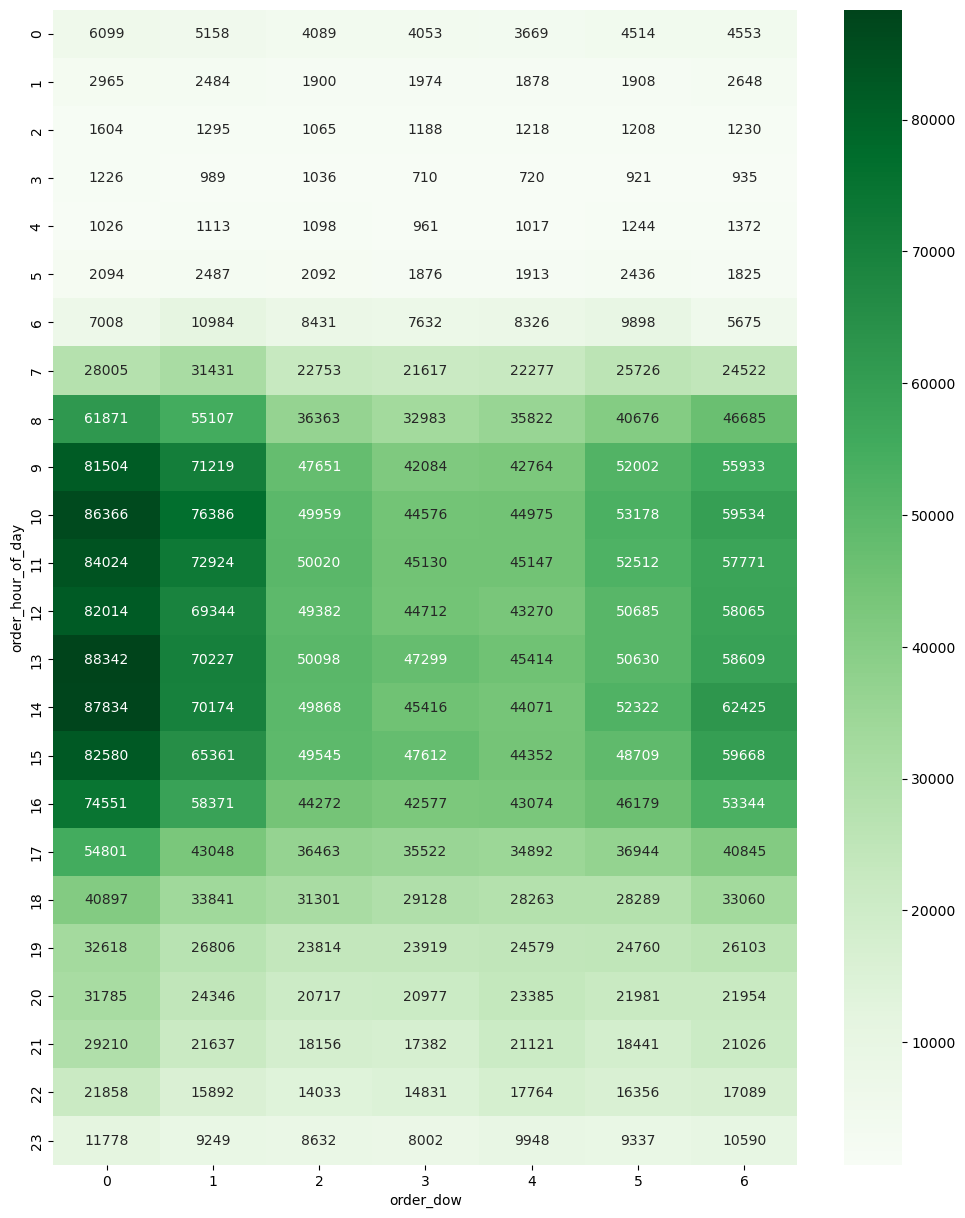

In [44]:
df = cluster_2[['order_hour_of_day','order_dow']].value_counts().unstack()

plt.figure(figsize=(12, 15))
sns.heatmap(df, annot = True, cmap = "Greens", fmt = '.0f')
plt.show()

###  집단별 재구매 주기 - days_since_prior_order

In [46]:
cluster_2['days_since_prior_order'].describe().apply(lambda x: format(x, '.2f'))

count    4914894.00
mean           6.37
std            4.89
min            0.00
25%            3.00
50%            5.00
75%            8.00
max           30.00
Name: days_since_prior_order, dtype: object

/var/folders/_n/svy9wdnj40n4g_jzln84knw40000gn/T/ipykernel_4906/2760499534.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


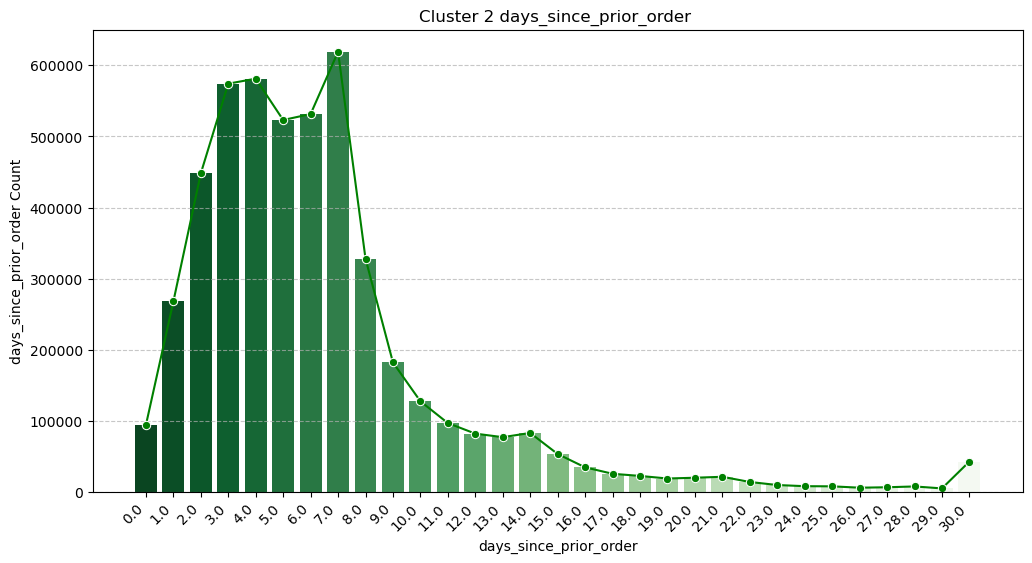

In [47]:
df = cluster_2['days_since_prior_order'].value_counts().reset_index()
df.columns = ['days_since_prior_order', 'count']

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x="days_since_prior_order",
    y="count",
    palette="Greens_r"
)
sns.lineplot(
    data=df,
    x="days_since_prior_order",
    y="count",
    color="Green",
    marker="o" 
)


# X축 레이블 회전 및 정렬
plt.xticks(rotation=45, ha="right")
plt.xlabel("days_since_prior_order")
plt.ylabel("days_since_prior_order Count")
plt.title("Cluster 2 days_since_prior_order ")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 출력
plt.show()